<a href="https://colab.research.google.com/github/GiorgioMB/UniversityProjects/blob/main/Hyperparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.2 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import os
import optuna
import multiprocessing as mp
import numpy as np
from sklearn.model_selection import train_test_split
from kaggle.api.kaggle_api_extended import KaggleApi
import tensorflow as tf
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Rescaling
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from hyperopt import fmin, tpe, hp
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix,f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom


In [4]:
##Run only once
os.environ['KAGGLE_CONFIG_DIR'] = '/kaggle.json'
dataset_name = 'puneet6060/intel-image-classification'
api = KaggleApi()
api.authenticate()
print("Authenticated, downloading dataset...")
api.dataset_download_files(dataset_name, path='/Users/micalettog/Desktop/Computer Science/Projects/BSDSA/ImageCNN/dataset/', unzip=True)
print("Dataset downloaded")
##

Authenticated, downloading dataset...
Dataset downloaded


In [5]:
batch_size = 32
img_height = 150
img_width = 150
num_classes = 6


data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
])


# Dataset loading code remains the same
dataset_test_dir = r"/Users/micalettog/Desktop/Computer Science/Projects/BSDSA/ImageCNN/dataset/seg_test/seg_test"
dataset_train_dir = r"/Users/micalettog/Desktop/Computer Science/Projects/BSDSA/ImageCNN/dataset/seg_train/seg_train"

train_ds = image_dataset_from_directory(
    dataset_train_dir,
    seed=341,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    dataset_test_dir,
    seed=341,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
# Applying data augmentation to the training dataset

train_ds_augmented = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

val_true_labels = []  # List to store true labels

for images, labels in val_ds:
    val_true_labels.extend(labels.numpy())

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [ ]:
host = 'sql11.freesqldatabase.com'
database_name = 'sql11665966'
database_user = 'sql11665966'
database_password = 'QK4GqB3M4z'
port = 3306

database_url = f"mysql+mysqlconnector://{database_user}:{database_password}@{host}:{port}/{database_name}"


In [49]:
from optuna.pruners import MedianPruner

study = optuna.create_study(study_name='distributed_study', direction='minimize', pruner=MedianPruner())

def objective(trial):
    kernel_size = trial.suggest_categorical('kernel_size', [4, 5, 6])
    num_filters = 48
    learning_rate = 0.000627151974189123
    dropout = trial.suggest_float('dropout', 0.03, 0.1)
    dropout2 = trial.suggest_float('dropout2', 0.03, 0.1)
    dropout3 = trial.suggest_float('dropout3', 0.03, 0.1)
    dropout4 = trial.suggest_float('dropout4', 0.03, 0.1)


    model = Sequential([
        data_augmentation,
        Rescaling(1./255),
        Conv2D(num_filters, kernel_size, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(num_filters, kernel_size, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(num_filters, kernel_size, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(num_filters, kernel_size, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        layers.GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(dropout),
        Dense(128, activation='relu'),
        Dropout(dropout2),
        Dense(64, activation='relu'),
        Dropout(dropout3),
        Dense(32, activation='relu'),
        Dropout(dropout4),
        Dense(16, activation='relu'),
        Dense(6, activation = 'softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
    try:
        model.fit(
            train_ds,
            epochs=20,
            validation_data=val_ds,
            verbose=2
        )
        val_loss, val_accuracy = model.evaluate(val_ds, verbose=2)
        return val_loss
    except Exception as e:
        return np.inf

study.optimize(objective, 10)

best_params = study.best_trial.params
print(best_params)

[I 2023-11-30 22:18:04,112] A new study created in memory with name: distributed_study


Epoch 1/20
439/439 - 16s - loss: 1.3963 - accuracy: 0.3913 - val_loss: 1.1427 - val_accuracy: 0.4977 - 16s/epoch - 35ms/step
Epoch 2/20
439/439 - 9s - loss: 1.1598 - accuracy: 0.4993 - val_loss: 1.0147 - val_accuracy: 0.5677 - 9s/epoch - 22ms/step
Epoch 3/20
439/439 - 12s - loss: 1.0295 - accuracy: 0.5857 - val_loss: 1.0211 - val_accuracy: 0.5893 - 12s/epoch - 28ms/step
Epoch 4/20
439/439 - 11s - loss: 0.9389 - accuracy: 0.6408 - val_loss: 0.8259 - val_accuracy: 0.6927 - 11s/epoch - 25ms/step
Epoch 5/20
439/439 - 11s - loss: 0.8679 - accuracy: 0.6802 - val_loss: 0.8447 - val_accuracy: 0.6940 - 11s/epoch - 25ms/step
Epoch 6/20
439/439 - 11s - loss: 0.7955 - accuracy: 0.7091 - val_loss: 0.6909 - val_accuracy: 0.7487 - 11s/epoch - 26ms/step
Epoch 7/20
439/439 - 10s - loss: 0.7638 - accuracy: 0.7242 - val_loss: 0.6994 - val_accuracy: 0.7460 - 10s/epoch - 22ms/step
Epoch 8/20
439/439 - 11s - loss: 0.7196 - accuracy: 0.7410 - val_loss: 0.6668 - val_accuracy: 0.7600 - 11s/epoch - 24ms/step
Ep

[I 2023-11-30 22:22:20,676] Trial 0 finished with value: 0.4848508834838867 and parameters: {'kernel_size': 4, 'dropout': 0.09376388346898239, 'dropout2': 0.06532546152632077, 'dropout3': 0.042229259926833865, 'dropout4': 0.04783538323463389}. Best is trial 0 with value: 0.4848508834838867.


Epoch 1/20
439/439 - 16s - loss: 1.3844 - accuracy: 0.3778 - val_loss: 1.3311 - val_accuracy: 0.3973 - 16s/epoch - 37ms/step
Epoch 2/20
439/439 - 10s - loss: 1.1676 - accuracy: 0.4974 - val_loss: 1.0762 - val_accuracy: 0.5207 - 10s/epoch - 24ms/step
Epoch 3/20
439/439 - 12s - loss: 1.0794 - accuracy: 0.5440 - val_loss: 1.0216 - val_accuracy: 0.5633 - 12s/epoch - 28ms/step
Epoch 4/20
439/439 - 11s - loss: 1.0105 - accuracy: 0.5907 - val_loss: 0.9566 - val_accuracy: 0.6340 - 11s/epoch - 26ms/step
Epoch 5/20
439/439 - 11s - loss: 0.9170 - accuracy: 0.6504 - val_loss: 0.8061 - val_accuracy: 0.6973 - 11s/epoch - 25ms/step
Epoch 6/20
439/439 - 11s - loss: 0.8558 - accuracy: 0.6814 - val_loss: 0.7645 - val_accuracy: 0.7200 - 11s/epoch - 26ms/step
Epoch 7/20
439/439 - 11s - loss: 0.7983 - accuracy: 0.7088 - val_loss: 0.7677 - val_accuracy: 0.7333 - 11s/epoch - 25ms/step
Epoch 8/20
439/439 - 11s - loss: 0.7562 - accuracy: 0.7256 - val_loss: 0.7484 - val_accuracy: 0.7367 - 11s/epoch - 25ms/step


[I 2023-11-30 22:26:58,854] Trial 1 finished with value: 0.5115832686424255 and parameters: {'kernel_size': 5, 'dropout': 0.08743838559602984, 'dropout2': 0.03354150836375619, 'dropout3': 0.03764030356004623, 'dropout4': 0.03503876836917904}. Best is trial 0 with value: 0.4848508834838867.


Epoch 1/20
439/439 - 16s - loss: 1.4032 - accuracy: 0.4047 - val_loss: 1.3443 - val_accuracy: 0.4627 - 16s/epoch - 37ms/step
Epoch 2/20
439/439 - 13s - loss: 1.1592 - accuracy: 0.5251 - val_loss: 1.0118 - val_accuracy: 0.5850 - 13s/epoch - 31ms/step
Epoch 3/20
439/439 - 11s - loss: 1.0622 - accuracy: 0.5757 - val_loss: 0.9954 - val_accuracy: 0.6077 - 11s/epoch - 25ms/step
Epoch 4/20
439/439 - 12s - loss: 0.9855 - accuracy: 0.6217 - val_loss: 0.9106 - val_accuracy: 0.6577 - 12s/epoch - 27ms/step
Epoch 5/20
439/439 - 12s - loss: 0.9151 - accuracy: 0.6568 - val_loss: 0.8105 - val_accuracy: 0.6903 - 12s/epoch - 27ms/step
Epoch 6/20
439/439 - 13s - loss: 0.8673 - accuracy: 0.6821 - val_loss: 0.8195 - val_accuracy: 0.7053 - 13s/epoch - 31ms/step
Epoch 7/20
439/439 - 10s - loss: 0.8102 - accuracy: 0.7027 - val_loss: 0.7672 - val_accuracy: 0.7290 - 10s/epoch - 24ms/step
Epoch 8/20
439/439 - 13s - loss: 0.7899 - accuracy: 0.7133 - val_loss: 0.7282 - val_accuracy: 0.7483 - 13s/epoch - 29ms/step


[I 2023-11-30 22:31:35,197] Trial 2 finished with value: 0.574216365814209 and parameters: {'kernel_size': 6, 'dropout': 0.05842176334371751, 'dropout2': 0.07623205343507748, 'dropout3': 0.07008670783577886, 'dropout4': 0.0497328736187352}. Best is trial 0 with value: 0.4848508834838867.


Epoch 1/20
439/439 - 14s - loss: 1.3694 - accuracy: 0.4000 - val_loss: 1.1723 - val_accuracy: 0.4757 - 14s/epoch - 33ms/step
Epoch 2/20
439/439 - 12s - loss: 1.1402 - accuracy: 0.5207 - val_loss: 0.9366 - val_accuracy: 0.6033 - 12s/epoch - 28ms/step
Epoch 3/20
439/439 - 12s - loss: 1.0211 - accuracy: 0.5955 - val_loss: 0.9393 - val_accuracy: 0.6380 - 12s/epoch - 27ms/step
Epoch 4/20
439/439 - 11s - loss: 0.9506 - accuracy: 0.6373 - val_loss: 0.8176 - val_accuracy: 0.6900 - 11s/epoch - 24ms/step
Epoch 5/20
439/439 - 12s - loss: 0.8600 - accuracy: 0.6848 - val_loss: 0.7233 - val_accuracy: 0.7310 - 12s/epoch - 28ms/step
Epoch 6/20
439/439 - 12s - loss: 0.8020 - accuracy: 0.7108 - val_loss: 0.7047 - val_accuracy: 0.7463 - 12s/epoch - 28ms/step
Epoch 7/20
439/439 - 11s - loss: 0.7345 - accuracy: 0.7383 - val_loss: 0.8307 - val_accuracy: 0.6990 - 11s/epoch - 25ms/step
Epoch 8/20
439/439 - 10s - loss: 0.6919 - accuracy: 0.7517 - val_loss: 0.6847 - val_accuracy: 0.7530 - 10s/epoch - 22ms/step


[I 2023-11-30 22:36:01,464] Trial 3 finished with value: 0.5201398134231567 and parameters: {'kernel_size': 4, 'dropout': 0.041634119149900436, 'dropout2': 0.05103744964239701, 'dropout3': 0.048213926554436376, 'dropout4': 0.05906977330309911}. Best is trial 0 with value: 0.4848508834838867.


Epoch 1/20
439/439 - 14s - loss: 1.4769 - accuracy: 0.3558 - val_loss: 1.2090 - val_accuracy: 0.4850 - 14s/epoch - 32ms/step
Epoch 2/20
439/439 - 9s - loss: 1.0863 - accuracy: 0.5614 - val_loss: 0.9775 - val_accuracy: 0.6323 - 9s/epoch - 21ms/step
Epoch 3/20
439/439 - 11s - loss: 0.9630 - accuracy: 0.6351 - val_loss: 1.0183 - val_accuracy: 0.6230 - 11s/epoch - 25ms/step
Epoch 4/20
439/439 - 11s - loss: 0.8703 - accuracy: 0.6761 - val_loss: 0.8717 - val_accuracy: 0.6787 - 11s/epoch - 26ms/step
Epoch 5/20
439/439 - 11s - loss: 0.8345 - accuracy: 0.6907 - val_loss: 0.7490 - val_accuracy: 0.7157 - 11s/epoch - 25ms/step
Epoch 6/20
439/439 - 10s - loss: 0.7709 - accuracy: 0.7230 - val_loss: 0.8248 - val_accuracy: 0.7050 - 10s/epoch - 23ms/step
Epoch 7/20
439/439 - 10s - loss: 0.7411 - accuracy: 0.7336 - val_loss: 0.6328 - val_accuracy: 0.7707 - 10s/epoch - 23ms/step
Epoch 8/20
439/439 - 12s - loss: 0.7028 - accuracy: 0.7479 - val_loss: 0.6269 - val_accuracy: 0.7680 - 12s/epoch - 28ms/step
Ep

[I 2023-11-30 22:40:20,571] Trial 4 finished with value: 0.506549060344696 and parameters: {'kernel_size': 4, 'dropout': 0.06934293148829877, 'dropout2': 0.08027964992204611, 'dropout3': 0.047320168584716854, 'dropout4': 0.05410603450825664}. Best is trial 0 with value: 0.4848508834838867.


Epoch 1/20
439/439 - 14s - loss: 1.3771 - accuracy: 0.3945 - val_loss: 1.4515 - val_accuracy: 0.4247 - 14s/epoch - 32ms/step
Epoch 2/20
439/439 - 11s - loss: 1.1300 - accuracy: 0.5353 - val_loss: 1.1430 - val_accuracy: 0.5697 - 11s/epoch - 25ms/step
Epoch 3/20
439/439 - 11s - loss: 1.0053 - accuracy: 0.6107 - val_loss: 0.8774 - val_accuracy: 0.6650 - 11s/epoch - 26ms/step
Epoch 4/20
439/439 - 12s - loss: 0.9215 - accuracy: 0.6611 - val_loss: 0.7713 - val_accuracy: 0.7163 - 12s/epoch - 26ms/step
Epoch 5/20
439/439 - 12s - loss: 0.8467 - accuracy: 0.6930 - val_loss: 0.7113 - val_accuracy: 0.7407 - 12s/epoch - 28ms/step
Epoch 6/20
439/439 - 11s - loss: 0.7801 - accuracy: 0.7214 - val_loss: 0.6773 - val_accuracy: 0.7553 - 11s/epoch - 24ms/step
Epoch 7/20
439/439 - 12s - loss: 0.7322 - accuracy: 0.7374 - val_loss: 0.6403 - val_accuracy: 0.7820 - 12s/epoch - 28ms/step
Epoch 8/20
439/439 - 12s - loss: 0.6912 - accuracy: 0.7539 - val_loss: 0.5949 - val_accuracy: 0.7933 - 12s/epoch - 26ms/step


[I 2023-11-30 22:45:18,429] Trial 5 finished with value: 0.4835354685783386 and parameters: {'kernel_size': 4, 'dropout': 0.06926692273600446, 'dropout2': 0.07112997036707623, 'dropout3': 0.0780814307539649, 'dropout4': 0.030436704275823536}. Best is trial 5 with value: 0.4835354685783386.


Epoch 1/20
439/439 - 14s - loss: 1.4322 - accuracy: 0.3682 - val_loss: 1.2440 - val_accuracy: 0.4667 - 14s/epoch - 32ms/step
Epoch 2/20
439/439 - 11s - loss: 1.1252 - accuracy: 0.5385 - val_loss: 0.9928 - val_accuracy: 0.5997 - 11s/epoch - 25ms/step
Epoch 3/20
439/439 - 11s - loss: 1.0015 - accuracy: 0.6141 - val_loss: 0.8889 - val_accuracy: 0.6613 - 11s/epoch - 25ms/step
Epoch 4/20
439/439 - 11s - loss: 0.9082 - accuracy: 0.6596 - val_loss: 0.8106 - val_accuracy: 0.7120 - 11s/epoch - 26ms/step
Epoch 5/20
439/439 - 11s - loss: 0.8365 - accuracy: 0.6947 - val_loss: 0.7307 - val_accuracy: 0.7297 - 11s/epoch - 25ms/step
Epoch 6/20
439/439 - 11s - loss: 0.7865 - accuracy: 0.7196 - val_loss: 0.7470 - val_accuracy: 0.7363 - 11s/epoch - 26ms/step
Epoch 7/20
439/439 - 10s - loss: 0.7472 - accuracy: 0.7304 - val_loss: 0.6380 - val_accuracy: 0.7797 - 10s/epoch - 23ms/step
Epoch 8/20
439/439 - 11s - loss: 0.6981 - accuracy: 0.7476 - val_loss: 0.6784 - val_accuracy: 0.7660 - 11s/epoch - 25ms/step


[I 2023-11-30 22:49:44,636] Trial 6 finished with value: 0.5574865937232971 and parameters: {'kernel_size': 5, 'dropout': 0.03692635175032521, 'dropout2': 0.07535309474889335, 'dropout3': 0.035022616215172456, 'dropout4': 0.0687275910093443}. Best is trial 5 with value: 0.4835354685783386.


Epoch 1/20
439/439 - 14s - loss: 1.4275 - accuracy: 0.3874 - val_loss: 1.2141 - val_accuracy: 0.4903 - 14s/epoch - 33ms/step
Epoch 2/20
439/439 - 12s - loss: 1.1487 - accuracy: 0.5215 - val_loss: 1.2336 - val_accuracy: 0.5210 - 12s/epoch - 27ms/step
Epoch 3/20
439/439 - 11s - loss: 1.0470 - accuracy: 0.5854 - val_loss: 1.0587 - val_accuracy: 0.5813 - 11s/epoch - 25ms/step
Epoch 4/20
439/439 - 11s - loss: 0.9639 - accuracy: 0.6258 - val_loss: 0.8616 - val_accuracy: 0.6723 - 11s/epoch - 25ms/step
Epoch 5/20
439/439 - 10s - loss: 0.8828 - accuracy: 0.6734 - val_loss: 0.7581 - val_accuracy: 0.7193 - 10s/epoch - 22ms/step
Epoch 6/20
439/439 - 11s - loss: 0.8346 - accuracy: 0.6965 - val_loss: 0.9309 - val_accuracy: 0.6800 - 11s/epoch - 24ms/step
Epoch 7/20
439/439 - 11s - loss: 0.7784 - accuracy: 0.7229 - val_loss: 0.7169 - val_accuracy: 0.7497 - 11s/epoch - 25ms/step
Epoch 8/20
439/439 - 12s - loss: 0.7472 - accuracy: 0.7372 - val_loss: 0.7454 - val_accuracy: 0.7553 - 12s/epoch - 28ms/step


[I 2023-11-30 22:53:36,299] Trial 7 finished with value: 0.5567973852157593 and parameters: {'kernel_size': 5, 'dropout': 0.05851279139421392, 'dropout2': 0.04760298927278862, 'dropout3': 0.03482235941104827, 'dropout4': 0.05593534110547675}. Best is trial 5 with value: 0.4835354685783386.


Epoch 1/20
439/439 - 14s - loss: 1.3790 - accuracy: 0.3905 - val_loss: 1.5986 - val_accuracy: 0.3527 - 14s/epoch - 31ms/step
Epoch 2/20
439/439 - 11s - loss: 1.1604 - accuracy: 0.4855 - val_loss: 1.0343 - val_accuracy: 0.5567 - 11s/epoch - 24ms/step
Epoch 3/20
439/439 - 11s - loss: 1.0548 - accuracy: 0.5693 - val_loss: 0.9731 - val_accuracy: 0.6070 - 11s/epoch - 25ms/step
Epoch 4/20
439/439 - 11s - loss: 0.9650 - accuracy: 0.6164 - val_loss: 0.8734 - val_accuracy: 0.6647 - 11s/epoch - 24ms/step
Epoch 5/20
439/439 - 10s - loss: 0.8999 - accuracy: 0.6652 - val_loss: 0.8558 - val_accuracy: 0.6687 - 10s/epoch - 22ms/step
Epoch 6/20
439/439 - 11s - loss: 0.8266 - accuracy: 0.6970 - val_loss: 0.6953 - val_accuracy: 0.7507 - 11s/epoch - 26ms/step
Epoch 7/20
439/439 - 11s - loss: 0.7497 - accuracy: 0.7346 - val_loss: 0.7807 - val_accuracy: 0.7037 - 11s/epoch - 25ms/step
Epoch 8/20
439/439 - 12s - loss: 0.7112 - accuracy: 0.7493 - val_loss: 0.6527 - val_accuracy: 0.7697 - 12s/epoch - 27ms/step


[I 2023-11-30 22:57:47,937] Trial 8 finished with value: 0.6094934344291687 and parameters: {'kernel_size': 4, 'dropout': 0.09001063524764508, 'dropout2': 0.09182622102526194, 'dropout3': 0.060266319368889244, 'dropout4': 0.08256281911013202}. Best is trial 5 with value: 0.4835354685783386.


Epoch 1/20
439/439 - 15s - loss: 1.6068 - accuracy: 0.2819 - val_loss: 1.2323 - val_accuracy: 0.4397 - 15s/epoch - 33ms/step
Epoch 2/20
439/439 - 11s - loss: 1.2033 - accuracy: 0.4911 - val_loss: 1.1123 - val_accuracy: 0.5800 - 11s/epoch - 26ms/step
Epoch 3/20
439/439 - 11s - loss: 1.0199 - accuracy: 0.6072 - val_loss: 0.8859 - val_accuracy: 0.6757 - 11s/epoch - 26ms/step
Epoch 4/20
439/439 - 11s - loss: 0.9048 - accuracy: 0.6628 - val_loss: 0.7708 - val_accuracy: 0.7160 - 11s/epoch - 25ms/step
Epoch 5/20
439/439 - 13s - loss: 0.8519 - accuracy: 0.6896 - val_loss: 0.7160 - val_accuracy: 0.7450 - 13s/epoch - 29ms/step
Epoch 6/20
439/439 - 12s - loss: 0.7932 - accuracy: 0.7108 - val_loss: 0.6808 - val_accuracy: 0.7567 - 12s/epoch - 26ms/step
Epoch 7/20
439/439 - 12s - loss: 0.7474 - accuracy: 0.7346 - val_loss: 0.7614 - val_accuracy: 0.7167 - 12s/epoch - 26ms/step
Epoch 8/20
439/439 - 11s - loss: 0.7364 - accuracy: 0.7392 - val_loss: 0.6879 - val_accuracy: 0.7443 - 11s/epoch - 26ms/step


[I 2023-11-30 23:02:38,432] Trial 9 finished with value: 0.5334668159484863 and parameters: {'kernel_size': 6, 'dropout': 0.03697329135869298, 'dropout2': 0.05644187519783355, 'dropout3': 0.055036886866220464, 'dropout4': 0.0967404609924713}. Best is trial 5 with value: 0.4835354685783386.


{'kernel_size': 4, 'dropout': 0.06926692273600446, 'dropout2': 0.07112997036707623, 'dropout3': 0.0780814307539649, 'dropout4': 0.030436704275823536}


In [31]:
params = {'kernel_size': (4, 4), 'l1_lambda': 8.103860954246165e-05, 'learning_rate': 0.0013802519171920088, 'num_filters': 16}
#F1 Score:  0.17546145040023758
#Precision:  0.17612905063723328
#Recall:  0.17533333333333334

In [43]:
params = {'num_filters': 32, 'kernel_size': 5, 'learning_rate': 0.000627151974189123, 'dropout': 0.0876013008754021}
#Better accuracy

In [51]:
params = {'num_filters': 48, 'kernel_size': 4, 'learning_rate': 0.0007327937745194752, 'dropout': 0.06926692273600446, 'dropout2': 0.07112997036707623, 'dropout3': 0.0780814307539649, 'dropout4': 0.030436704275823536}

In [32]:
from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
    tf.keras.layers.GaussianNoise(0.2)
])

{'num_filters': 48, 'kernel_size': 4, 'learning_rate': 0.0007327937745194752, 'dropout': 0.06926692273600446, 'dropout2': 0.07112997036707623, 'dropout3': 0.0780814307539649, 'dropout4': 0.030436704275823536}
Training the model
Epoch 1/50
439/439 - 14s - loss: 1.4115 - accuracy: 0.3682 - val_loss: 1.1735 - val_accuracy: 0.5027 - 14s/epoch - 32ms/step
Epoch 2/50
439/439 - 11s - loss: 1.1703 - accuracy: 0.4833 - val_loss: 1.0402 - val_accuracy: 0.5727 - 11s/epoch - 25ms/step
Epoch 3/50
439/439 - 11s - loss: 1.0053 - accuracy: 0.6006 - val_loss: 0.8991 - val_accuracy: 0.6447 - 11s/epoch - 25ms/step
Epoch 4/50
439/439 - 11s - loss: 0.9299 - accuracy: 0.6370 - val_loss: 0.8451 - val_accuracy: 0.6837 - 11s/epoch - 24ms/step
Epoch 5/50
439/439 - 10s - loss: 0.8496 - accuracy: 0.6848 - val_loss: 0.7451 - val_accuracy: 0.7227 - 10s/epoch - 22ms/step
Epoch 6/50
439/439 - 11s - loss: 0.7729 - accuracy: 0.7216 - val_loss: 0.7057 - val_accuracy: 0.7463 - 11s/epoch - 25ms/step
Epoch 7/50
439/439 - 1

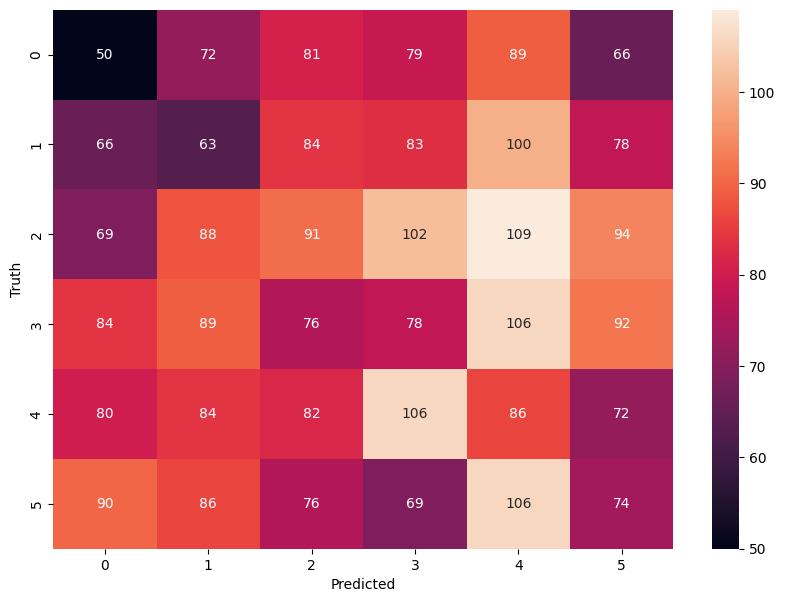

94/94 [==============================] - 2s 22ms/step
F1 Score:  0.17834281411433137
Precision:  0.17877273149248984
Recall:  0.17866666666666667


In [52]:
print(params)
model = Sequential([
        data_augmentation,
        Rescaling(1./255),
        Conv2D(params['num_filters'], params['kernel_size'], activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(params['num_filters'], params['kernel_size'], activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(params['num_filters'], params['kernel_size'], activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(params['num_filters'], params['kernel_size'], activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        layers.GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(params['dropout']),
        Dense(128, activation='relu'),
        Dropout(params['dropout2']),
        Dense(64, activation='relu'),
        Dropout(params['dropout3']),
        Dense(32, activation='relu'),
        Dropout(params['dropout4']),
        Dense(16, activation='relu'),
        Dense(6, activation = 'softmax')
    ])
optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

print("Training the model")
history = model.fit(
    train_ds,
    epochs = 50,
    validation_data= val_ds,
    verbose = 2
)
print("Evaluating the model")
test_loss, test_accuracy = model.evaluate(val_ds)
print("Test accuracy: ", test_accuracy)
y_pred = np.argmax(model.predict(val_ds), axis=-1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)
confusion_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(confusion_mat, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
y_pred = np.argmax(model.predict(val_ds), axis=-1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
print("F1 Score: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)

In [13]:
params = {'kernel_size': (3, 3), 'l1_lambda': 8.460106419050254e-06, 'learning_rate': 0.00034391529706269164, 'num_filters': 16}
